# **Cifar-10 Unsupervised Clustering**

---

### Michael Mars, 2023

In [ ]:
# install openTSNE which incorporates latest improvements to the original t-SNE algorithm  
%pip install openTSNE

# install latest scikit-image if not installed
%pip install --upgrade scikit-image

## Load Cifar-10 dataset

In [3]:
import numpy as np
from keras.datasets import cifar10

import warnings 
warnings.filterwarnings('ignore')


# The data, split between train and test sets:
(x_train_, y_train_), (x_test_, y_test_) = cifar10.load_data()
y_train_ = np.squeeze(y_train_)

CIFAR10_CLASSES = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


print('original classes:', CIFAR10_CLASSES)
print('x_train shape:', x_train_.shape)
print('y_train shape:', y_train_.shape)


170498071/170498071 [==============================] - 2s 0us/step
original classes: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)


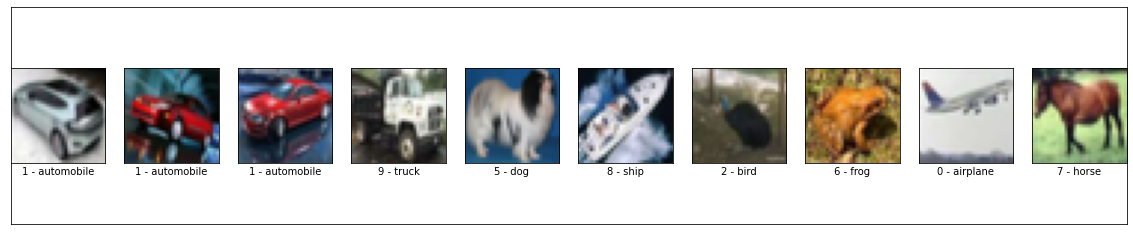

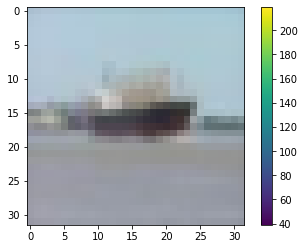

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper method to display random 10 images from a given dataset 
def display_images(images, predictions, labels, size=10):
  indexes = np.random.choice(len(predictions), size=size)
  imgs = images[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((size,))
  # n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(str(class_index) + ' - ' + labels[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[i])

display_images(x_train_, y_train_, LABELS)

plt.figure()
plt.imshow(x_train_[np.random.choice(len(y_train_))])
plt.colorbar()

## Reduce given dataset to have fewer classes 


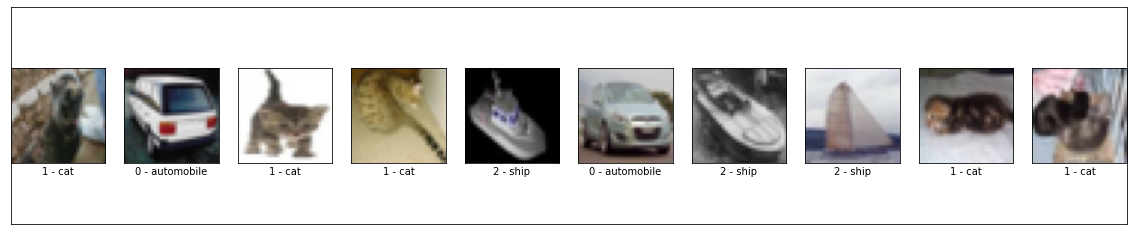

In [5]:
SUB_CLASSES = [1, 3, 8]
SUB_LABELS = ['automobile', 'cat', 'ship']


def reduce_classes(values, x_train, y_train, x_test, y_test):

    # Train reductions:
    indices = np.where(np.isin(y_train, values))[0]
    y_train_reduced = y_train[indices]
    x_train_reduced = x_train[indices]

    # The labels are 3,8 and need to be changed to 0,1
    for i in range(len(values)):
        y_train_reduced[y_train_reduced==values[i]] = i


    # Test reductions:
    indices = np.where(np.isin(y_test, values))[0]
    y_test_reduced = y_test[indices]
    x_test_reduced = x_test[indices]

    # The labels are 3,8 and need to be changed to 0,1
    for i in range(len(values)):
        y_test_reduced[y_test_reduced==values[i]] = i

    classes_reduced = {k: v for k,v in CIFAR10_CLASSES.items() if k in values}
    classes_reduced = {i:v for i,(k, v) in enumerate(classes_reduced.items())}

    return (x_train_reduced, y_train_reduced), (x_test_reduced, y_test_reduced), classes_reduced


def load_data(sub_classes):
    # SUB_CLASSES = [1, 3, 8] #automobile, cat, ship
    (x_train, y_train), (x_test, y_test), classes_reduced = reduce_classes(sub_classes, x_train_, y_train_, x_test_, y_test_)
    y_train, y_test = y_train.ravel(), y_test.ravel()
    return (x_train, y_train), (x_test, y_test), classes_reduced


(x_train, y_train), (x_test, y_test), classes_reduced = load_data(SUB_CLASSES)

display_images(x_train, y_train, SUB_LABELS)

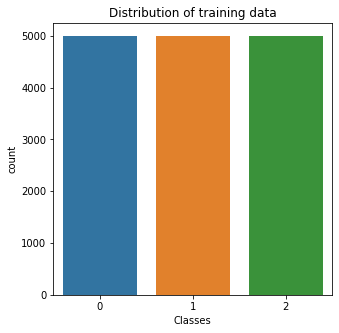

In [6]:
import seaborn as sns

# Count plot for training set
fig = plt.figure(figsize=(5, 5))
sns.countplot(x=y_train.ravel())
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()



---




# Feature Extraction 
I used transfer learning to leverage a pre-trained CNN - InceptionV3 - that was trained on object classification tasks. 
The final layer of the network is a fully connected layer designed to distinguish between 1000 different categories in the ImageNet database. 
I removed the final layer and saved the network in a new model.

Model input size is 299 x 299. 
Since our input image size is (32 x 32), I first upsample the image by factor of (9x9) to transform it to (288 x 288).

In [7]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras import Model
from keras.layers import Input


def feature_extractor():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  resize = tf.keras.layers.UpSampling2D(size=(9,9))(inputs)
  inc_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')(resize)
  model = Model(inputs=inputs, outputs=inc_model)
  return model

model = feature_extractor()
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 288, 288, 3)      0         
 )                                                               
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [8]:
import os
from keras.applications.inception_v3 import InceptionV3, preprocess_input

N_SAMPLES = 5000

x_train = x_train[:N_SAMPLES]
y_train = y_train[:N_SAMPLES]


if os.path.exists('features_train.npz'):
  features = np.load('features_train.npz')['features']
else:
  # pre-process the train images
  inception_input_train = preprocess_input(x_train)

  # extract, process, and save features
  features = model.predict(inception_input_train)
  features = np.squeeze(features)
  np.savez('features_train', features=features)
  print('features saved (train)')

features.shape
features[0].shape

feat_reshaped = features.reshape([features.shape[0], np.prod(features.shape[1:])]).astype('float64')[:N_SAMPLES]
feat_reshaped.shape

157/157 [==============================] - 806s 5s/step
features saved (train)


(5000, 2048)

## Perform PCA and t-SNE to reduce the dimensionality of the features

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 3.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.613153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.369751
[t-SNE] KL divergence after 1000 iterations: 2.383728


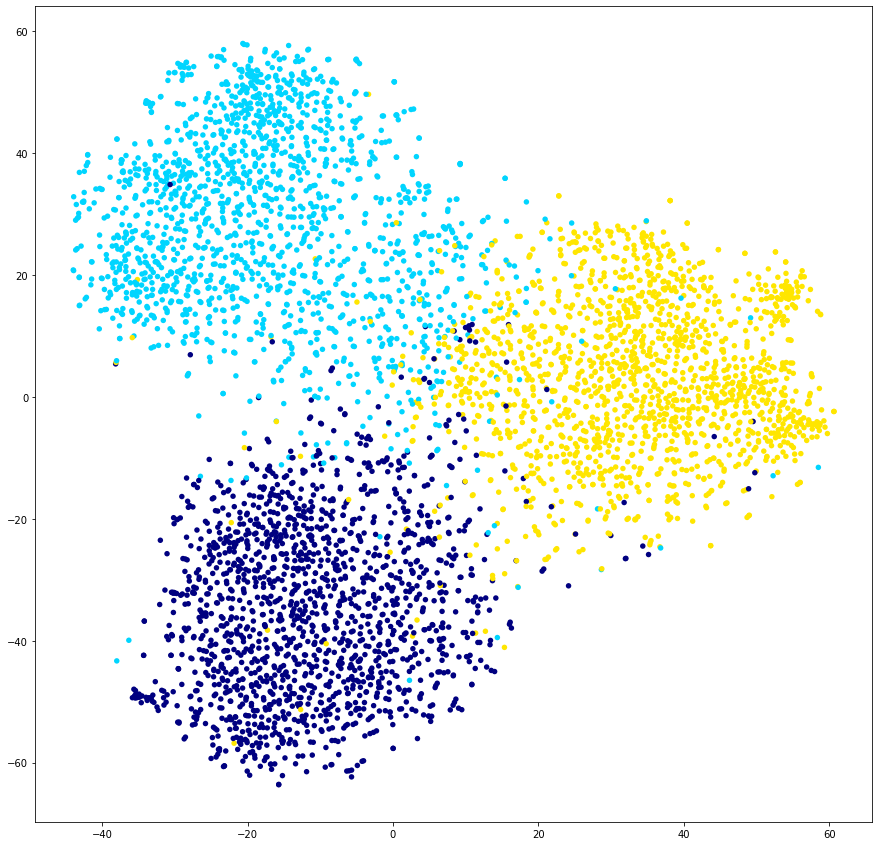

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
x_pca = pca.fit_transform(feat_reshaped)
print(x_pca.shape)

# Plot the features PCA results 
plt.figure(figsize=(15,15))
plt.scatter(x_pca[:,0], x_pca[:,1], c=plt.cm.jet(y_train/3), s=30, edgecolors='none')
plt.title('PCA')
plt.show()


x_tsne = TSNE(n_components=2, perplexity=30, metric="euclidean", n_jobs=8, random_state=42, verbose=True).fit_transform(feat_reshaped)

# Plot the features TSNE results 
plt.figure(figsize=(15,15))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=plt.cm.jet(y_train/3), s=30, edgecolors='none')
plt.title('tSNE')
plt.show()


# from umap import UMAP
# umap_2d = UMAP(n_components=2, init='random', random_state=0).fit_transform(feat_reshaped)

 ## Perform clustering on the t-SNE transformed features


KMeans
Silhouette Score:  0.567
Calinski-Harabasz Index:  8961.165
Davies-Bouldin Index:  0.594
Inertia:  1689767.625



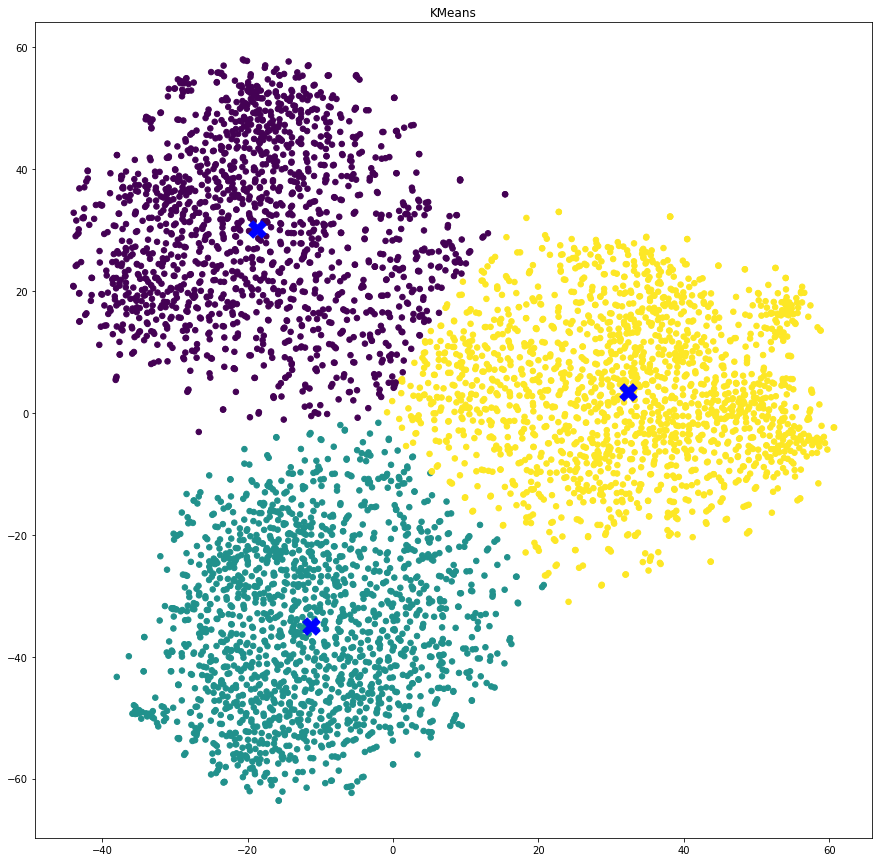


DBSCAN
Silhouette Score:  -0.175
Calinski-Harabasz Index:  12.986
Davies-Bouldin Index:  0.748



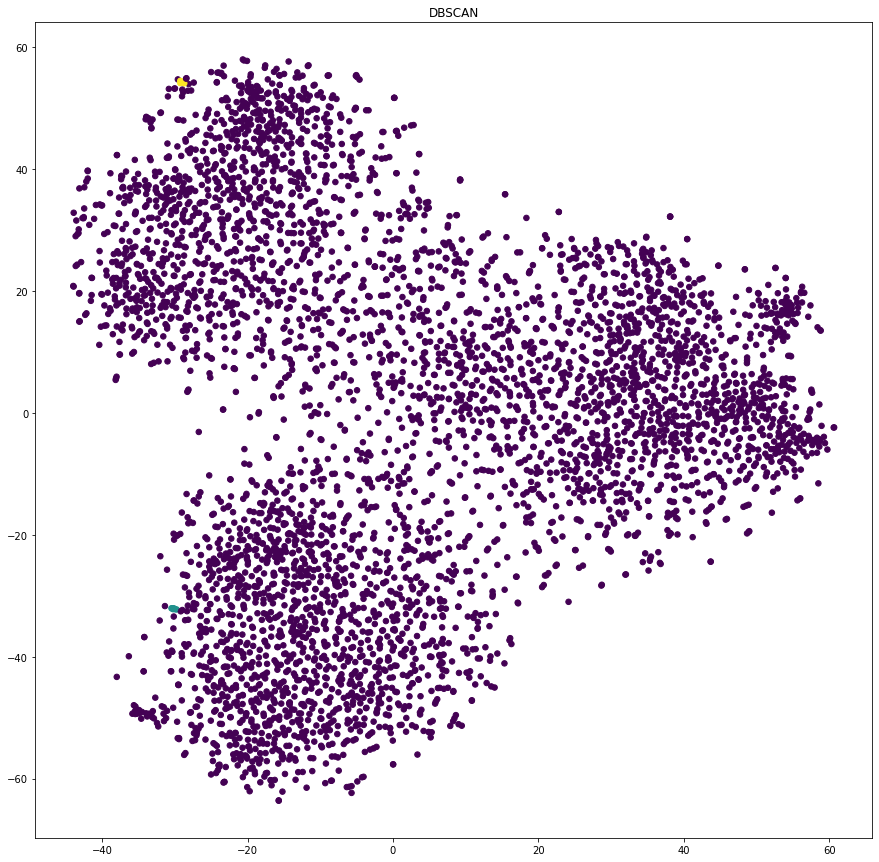


Hierarchical
Silhouette Score:  0.559
Calinski-Harabasz Index:  8709.312
Davies-Bouldin Index:  0.609



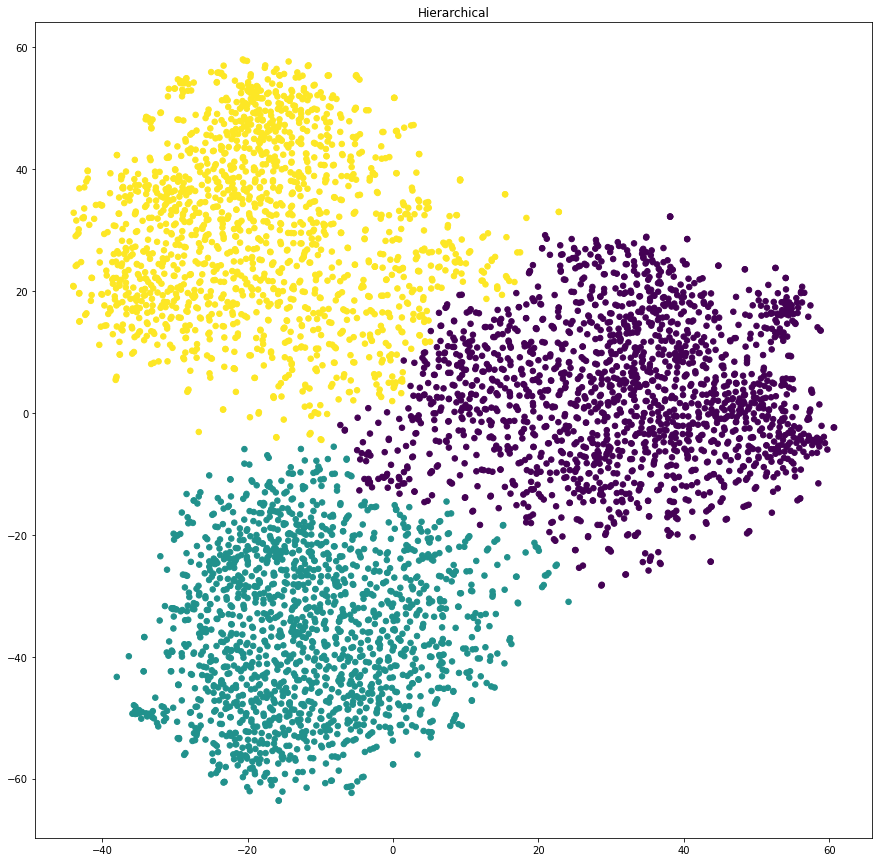

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances


# Defining a function "cluster" to cluster the data using various clustering algorithms
def cluster(X, cluster_type="KMeans"):   
  if cluster_type == "KMeans":
      cmodel = KMeans(n_clusters=3)
  elif cluster_type == "MiniBatchKMeans":
      cmodel = MiniBatchKMeans(n_clusters=3)
  elif cluster_type == "DBSCAN":
      cmodel = DBSCAN(eps=0.3, min_samples=5)
  elif cluster_type == "Hierarchical":
      cmodel = AgglomerativeClustering(n_clusters=3)
  elif cluster_type == "GMM":
      cmodel = GaussianMixture(n_components=3)
  else:
    return None, None

  # Fit the features and predict using the chosen clustering algorithm
  labels = cmodel.fit_predict(X)
  return x_clust, labels, cmodel

    
# Evaluate the clustering results using different evaluation metrics
def evaluate_clustering(X, labels):
  silhouette = silhouette_score(X, labels)
  calinski = calinski_harabasz_score(X, labels)
  davies = davies_bouldin_score(X, labels)
  # dunn = dunn_index(X, labels)
  return silhouette, calinski, davies

# MEthod to visualize the clustering results
def visualize_clusters(X, labels, title, centroids=None):
  plt.figure(figsize=(15,15))
  plt.scatter(X[:,0], X[:,1], c=labels, s=30)
  if centroids is not None:
    plt.scatter(centroids[:, 0], centroids[:, 1], s = 300, c = 'blue', marker='X')    
  plt.title(title)
  plt.show()


x_clust, labels, cmodel = cluster(x_tsne, cluster_type="KMeans")
silhouette, calinski, davies = evaluate_clustering(x_clust, labels)
print("\nKMeans")
print(f"Silhouette Score:  {silhouette:.3f}", )
print(f"Calinski-Harabasz Index:  {calinski:.3f}")
print(f"Davies-Bouldin Index:  {davies:.3f}")
# print(f"Dunn Index:  {dunn:.3f}")
print(f'Inertia:  {cmodel.inertia_}')
print()

visualize_clusters(x_clust, labels, "KMeans", cmodel.cluster_centers_)


x_clust, labels, cmodel = cluster(x_tsne, cluster_type="DBSCAN")
silhouette, calinski, davies = evaluate_clustering(x_clust, labels)
print("\nDBSCAN")
print(f"Silhouette Score:  {silhouette:.3f}", )
print(f"Calinski-Harabasz Index:  {calinski:.3f}")
print(f"Davies-Bouldin Index:  {davies:.3f}")
# print(f"Dunn Index:  {dunn:.3f}")
print()

visualize_clusters(x_clust, labels, "DBSCAN")


x_clust, labels, cmodel = cluster(x_tsne, cluster_type="Hierarchical")
silhouette, calinski, davies = evaluate_clustering(x_clust, labels)
print("\nHierarchical")
print(f"Silhouette Score:  {silhouette:.3f}", )
print(f"Calinski-Harabasz Index:  {calinski:.3f}")
print(f"Davies-Bouldin Index:  {davies:.3f}")
# print(f"Dunn Index:  {dunn:.3f}")
print()

visualize_clusters(x_clust, labels, "Hierarchical")




---



## Associate clusters to their probable labels

In [35]:
from sklearn import metrics
from sklearn.metrics import accuracy_score


# Associate most probable label with each cluster in clustering model
def retrieve_info(cluster_labels, y_train):
  reference_labels = {}
  # For loop to run through each label of cluster label
  for i in np.unique(cluster_labels):     # for i in range(len(np.unique(kmeans.labels_))):
      index = np.where(cluster_labels == i,1,0)
      num = np.bincount(y_train[index==1]).argmax()
      reference_labels[i] = num
      # print(f'cluster {i} - label {num} - {labels[num]}')
  return reference_labels


reference_labels = retrieve_info(labels, y_train)
print('reference_labels:', reference_labels)

number_labels = np.random.rand(len(labels))
for i in range(len(labels)):
  number_labels[i] = reference_labels[labels[i]]


# Comparing predicted and actual values
print(number_labels[:20].astype('int'))
print(y_train[:20])

# Calculate accuracy score
print('accuracy_score:', accuracy_score(number_labels, y_train))


reference_labels: {0: 2, 1: 0, 2: 1}
[0 0 2 1 1 1 1 0 1 2 1 1 0 0 0 2 0 0 2 0]
[0 0 2 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 2 0]
accuracy_score: 0.941


## Test images

4/4 [==============================] - 16s 4s/step
reference_labels: {0: 1, 1: 2, 2: 0}


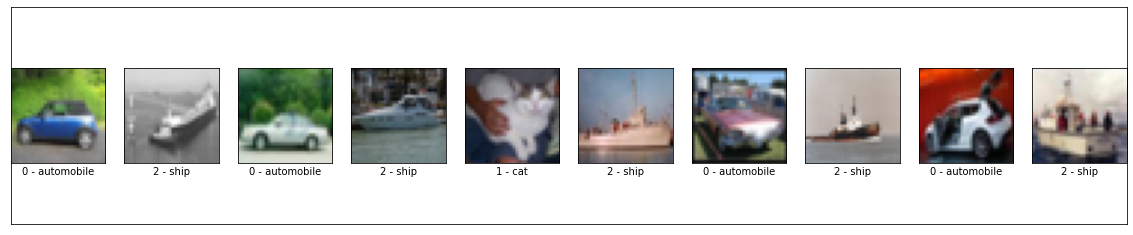

In [39]:
# Predict the labels for sample images using chosen clustering algorithm

x_test_100 = x_test[:100]
y_test_100 = y_test[:100]
inception_input_test = preprocess_input(x_test_100)

features_test = model.predict(inception_input_test)
features_test = np.squeeze(features_test)
features_test = features_test.reshape([features_test.shape[0], np.prod(features_test.shape[1:])]).astype('float64')

labels = cmodel.fit_predict(features_test)

reference_labels = retrieve_info(labels, y_test_100)
print('reference_labels:', reference_labels)

number_labels = np.random.rand(len(labels))
for i in range(len(labels)):
  number_labels[i] = reference_labels[labels[i]]

display_images(x_test_100, number_labels.astype('int'), SUB_LABELS)